### Import librairies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
from collections import Counter

In [2]:
df = pd.read_csv("sample-data.csv")
print("Number of rows : ", df.shape[0])
print()
df.head()

Number of rows :  500



,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


### Text processing

In [3]:
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import en_core_web_sm
nlp = en_core_web_sm.load()

from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
rm_tags = re.compile(r'<[^>]+>')

df["clean_text"] = df.description\
                    .apply(lambda x: rm_tags.sub("", x))\
                    .str.replace(r"[^A-Za-z]+", " ", regex=True)\
                    .str.lower()\
                    .apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.text not in STOP_WORDS) and (token.lemma_ not in STOP_WORDS)]))\
                    .str.replace(" +", " ")\
                    .apply(lambda x: " ".join([ch for ch in x.split() if len(ch)>1]))
df.head()

,id,description,clean_text
0,1,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,active sport brief superbreathable fly brief m...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice alpine ja...


In [6]:
print("Before preprocessing : ", df.iloc[1, 1])
print("After preprocessing : ", df.iloc[1, 2])

Before preprocessing :  Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common

### Part 1 - Group of items with similar descriptions

Vectorization

In [7]:
vectorizer = TfidfVectorizer(stop_words="english", smooth_idf=True)
X = vectorizer.fit_transform(df["clean_text"])
dense = X.toarray()

vectorizer.get_feature_names_out()

array(['abandon', 'ability', 'able', ..., 'zipping', 'zips', 'zone'],
      dtype=object)

In [8]:
df_vectorized = pd.DataFrame(dense, columns=vectorizer.get_feature_names_out())
df_vectorized.head()

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,zinger,zip,zipped,zipper,zippered,zippers,zippersfabric,zipping,zips,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.056330,0.266595,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.162424,0.000000,0.0,0.0,0.0,0.0,0.0


Groups of products with similar description

In [9]:
dbscan = DBSCAN(eps=0.725, min_samples=4, metric="cosine")
dbscan.fit(df_vectorized)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 21,  72, 291,  34,  21,   9,   8,  24,   4,   5,   7,   4]))

In [10]:
df["labels"] = dbscan.labels_
df.head()

,id,description,clean_text,labels
0,1,Active classic boxers - There's a reason why o...,active classic boxer reason boxer cult favorit...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer brief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,active sport brief superbreathable fly brief m...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pant skin climb ice switch rock t...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridge steep ice alpine ja...,1


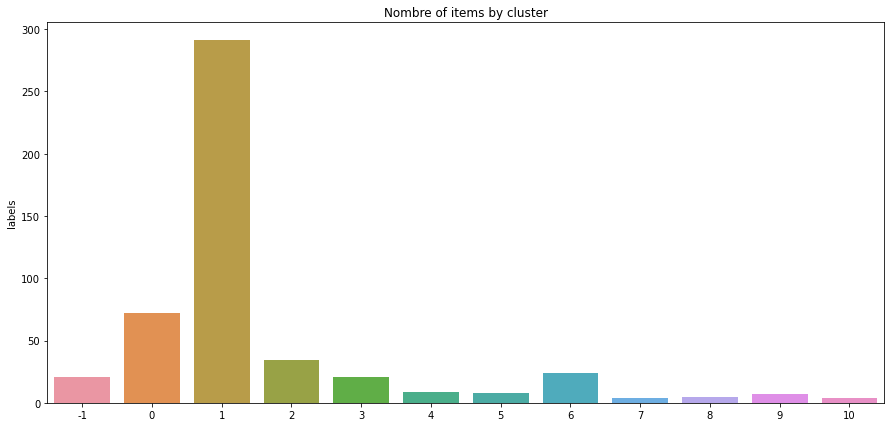

In [11]:
plt.figure(figsize=(15,7))
plt.title("Nombre of items by cluster")
sns.barplot(x=df["labels"].unique() , y=df["labels"].value_counts()[df["labels"].unique()]);

Create a dataframe with vocabulary for each cluster

In [12]:
clusters_vocab = pd.DataFrame()
cluster_dict = {}
for i in range(11):
    name_cluster = "cluster" + str(i)
    cluster_dict[str(i)] = dict(sorted(dict(Counter(" ".join(df.loc[df.labels==i, "clean_text"]).split()).most_common(15)).items(), key=lambda item: item[1], reverse=True))
    clusters_vocab[name_cluster] = cluster_dict[str(i)]
clusters_vocab.reset_index(drop=True, inplace=True)
clusters_vocab

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10
0,recycle,oz,pocket,nylon,oz,photo,merino,web,support,fabric,barely
1,oz,recycle,polyester,oz,brim,outside,wool,nylon,insole,polyester,recycle
2,polyester,pocket,strap,coverage,water,poster,recycle,buckle,high,microfiber,bra
3,fabric,recyclable,water,spandex,nylon,print,wash,belt,filtration,proprietary,polyester
4,recyclable,thread,deni,blend,headband,life,polyester,dry,mesh,breathable,moisture
5,common,common,mesh,line,soft,year,skin,lightweight,midsole,hydrostorm,spandex
6,thread,organic,oz,detail,detail,ve,dry,aluminum,neoprene,barrier,fabric
7,sun,cotton,shoulder,style,adjustable,pay,knit,quick,synthetic,oz,oz
8,dry,fabric,zippered,soft,rear,tribute,odor,strong,leather,deluge,breathe
9,protection,detail,polyurethane,improve,buckle,human,construction,strap,mold,dwr,lace


WordCloud per cluster

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 0 -*-*-*-*-*-*-*-*-*-*-*-*


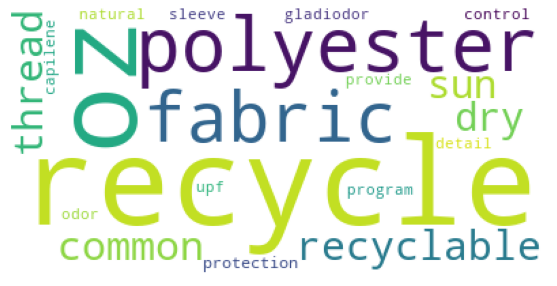

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 1 -*-*-*-*-*-*-*-*-*-*-*-*


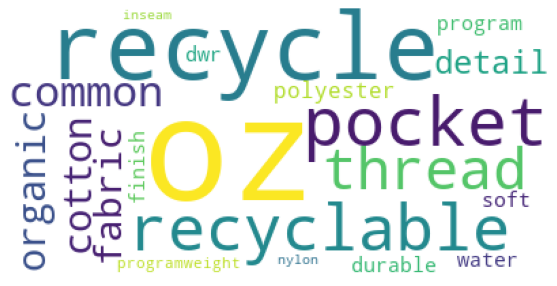

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 2 -*-*-*-*-*-*-*-*-*-*-*-*


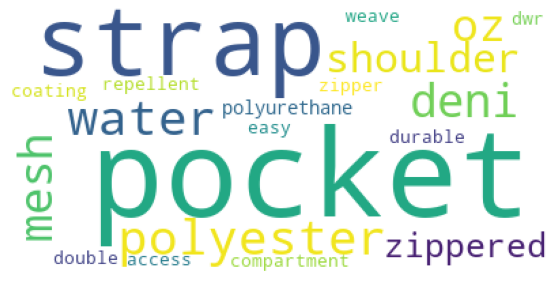

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 3 -*-*-*-*-*-*-*-*-*-*-*-*


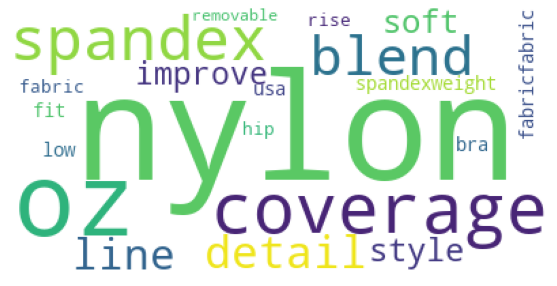

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 4 -*-*-*-*-*-*-*-*-*-*-*-*


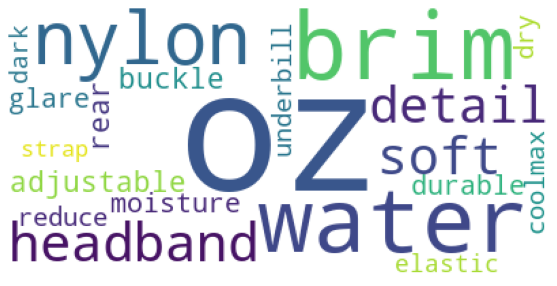

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 5 -*-*-*-*-*-*-*-*-*-*-*-*


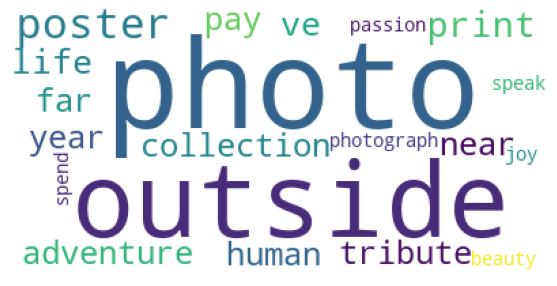

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 6 -*-*-*-*-*-*-*-*-*-*-*-*


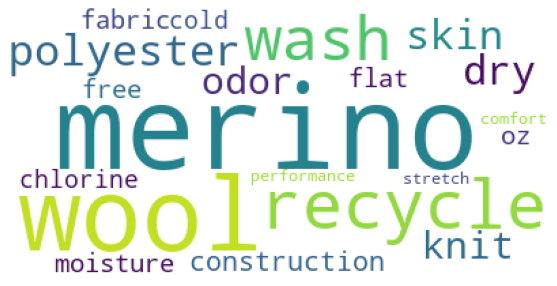

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 7 -*-*-*-*-*-*-*-*-*-*-*-*


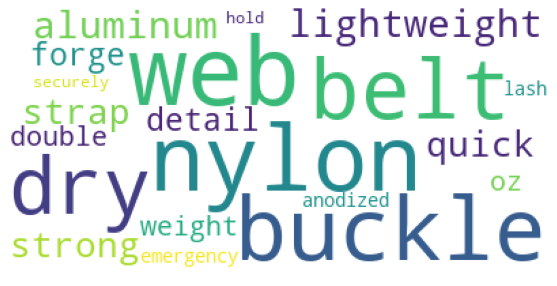

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 8 -*-*-*-*-*-*-*-*-*-*-*-*


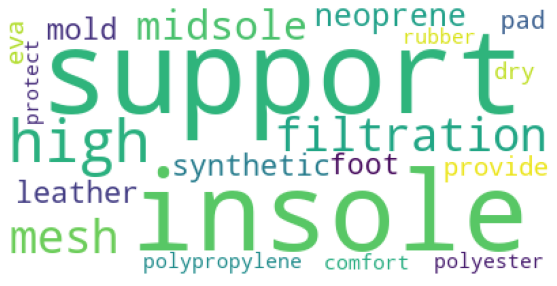

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 9 -*-*-*-*-*-*-*-*-*-*-*-*


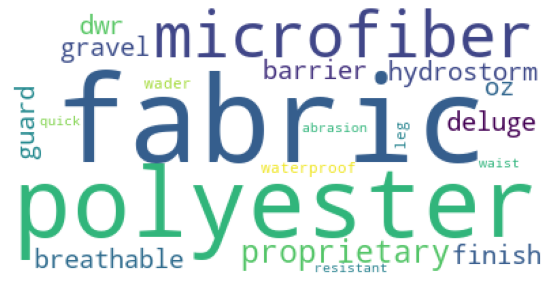

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for the group 10 -*-*-*-*-*-*-*-*-*-*-*-*


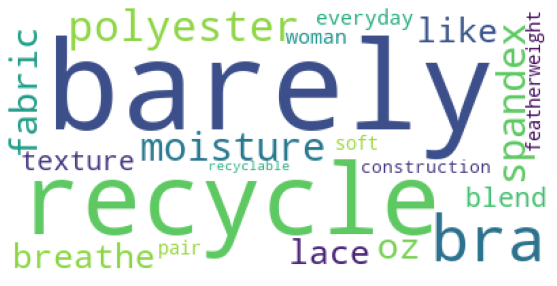

In [13]:
wd = WordCloud(stopwords=STOP_WORDS, collocations=False, max_words=20, background_color='white')

for i in range(len(np.unique(df.labels))-1):
    cloud = wd.generate(" ".join(df.loc[df.labels==i, "clean_text"]))
    plt.figure(figsize=(12,5))
    print("-*"*12,"The 20 most common words for the group {}".format(i),"-*"*12)
    # plt.title("Most words for group {} ".format(i))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()

### Part 2 - Recommender system

In [19]:
def find_similar_items():
   item_id = input("Please enter the ID of the item you are interested in (between {} & {})".format(df.id.unique().min(), df.id.unique().max()))
   try:
      item_id = int(item_id)
   except ValueError:
      raise ValueError("Please enter only numbers!")
   else:
      if item_id in (df.id.unique()):
         item_label = df[df.id==item_id]["labels"].iloc[0]
         if item_label==-1:
            print("There is no item similar to the one you are interested in")
         else:
            print("You might also be interested by these products, check them out : {}"\
                  .format(df.loc[(df.labels==item_label) & (df.id!=item_id), "id"]\
                          # Select random items each time
                          .sample(n=[5 if len(df.loc[df.labels==item_label, "id"])>5 else len(df.loc[df.labels==item_label, "id"])-1][0])\
                                 .tolist()))

find_similar_items()

You might also be interested by these products, check them out : [18, 21, 348, 411, 264]


### Part 3 - Topic modeling

Dimensionality reduction & LSA topic modeling

In [15]:
svd = TruncatedSVD(n_components=10, random_state=0)
lsa = svd.fit_transform(df_vectorized)

In [16]:
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_"+str(i) for i in range(1, 11)])
topic_encoded_df["id"] = df["id"]
topic_encoded_df["descritpion"] = df["description"]
topic_encoded_df["clean_text"] = df["clean_text"]
topic_encoded_df["max_topic_v"] = topic_encoded_df.iloc[:, 0:10].max(axis=1)
topic_encoded_df["main_topic"] = np.argmax(topic_encoded_df.iloc[:, 0:10].to_numpy(), axis=1)+1
topic_encoded_df.tail()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,id,descritpion,clean_text,max_topic_v,main_topic
495,0.337043,-0.071596,0.395957,0.076470,-0.250873,0.029018,-0.163017,-0.042642,-0.297903,-0.127662,496,Cap 2 bottoms - Cut loose from the maddening c...,cap cut loose madden crowd search undone capil...,0.395957,3
496,0.377828,-0.076138,0.494412,-0.003434,-0.299818,0.061081,-0.092023,0.032933,-0.258038,-0.021293,497,Cap 2 crew - This crew takes the edge off fick...,cap crew crew edge fickle weather clearing con...,0.494412,3
497,0.338382,-0.213548,-0.051626,-0.240337,-0.003468,0.207366,0.006801,-0.174302,0.040153,0.067915,498,All-time shell - No need to use that morning T...,time shell need use morning time umbrella time...,0.338382,1
498,0.336250,0.079545,-0.136249,0.350357,0.039815,0.085339,-0.188932,0.062776,-0.041302,0.044769,499,All-wear cargo shorts - All-Wear Cargo Shorts ...,wear cargo short wear cargo short bask glory s...,0.350357,4
499,0.381603,0.071075,-0.184638,0.366320,0.040558,0.094725,-0.180726,0.065130,-0.011428,0.026581,500,All-wear shorts - Time to simplify? Our All-We...,wear short time simplify wear short prove shor...,0.381603,1


Wordcloud per topic

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 1 -*-*-*-*-*-*-*-*-*-*-*-*


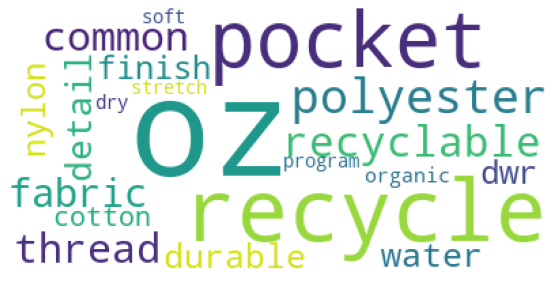

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 2 -*-*-*-*-*-*-*-*-*-*-*-*


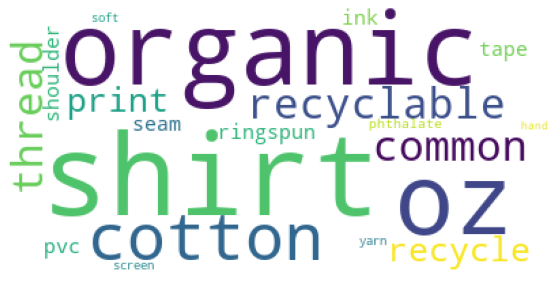

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 3 -*-*-*-*-*-*-*-*-*-*-*-*


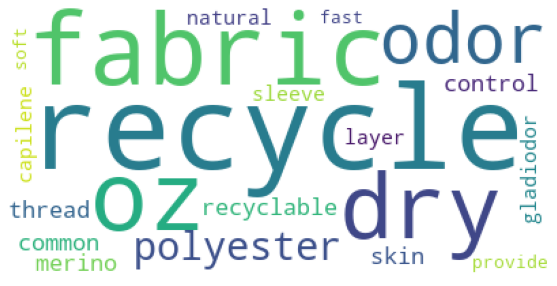

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 4 -*-*-*-*-*-*-*-*-*-*-*-*


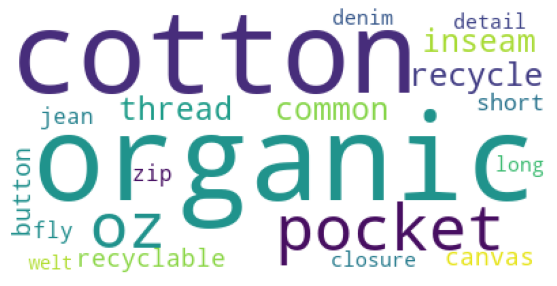

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 5 -*-*-*-*-*-*-*-*-*-*-*-*


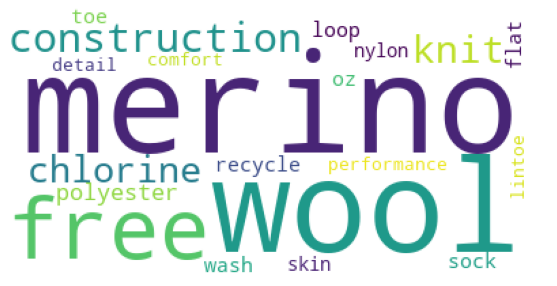

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 6 -*-*-*-*-*-*-*-*-*-*-*-*


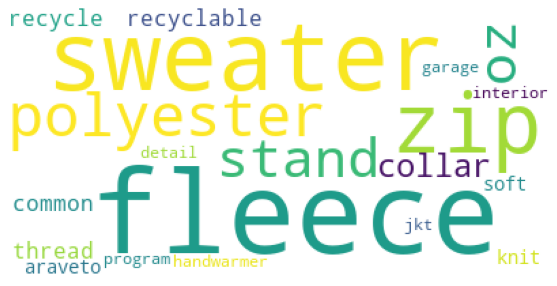

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 7 -*-*-*-*-*-*-*-*-*-*-*-*


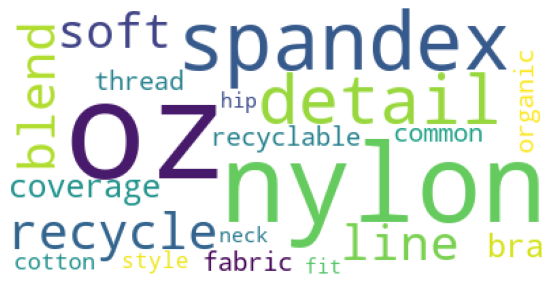

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 8 -*-*-*-*-*-*-*-*-*-*-*-*


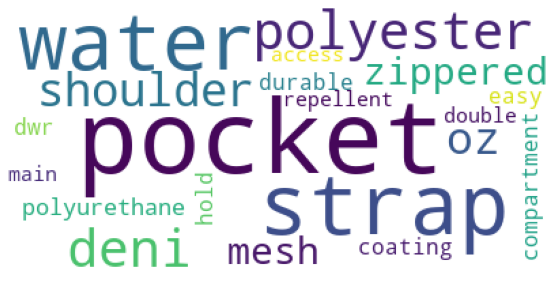

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 9 -*-*-*-*-*-*-*-*-*-*-*-*


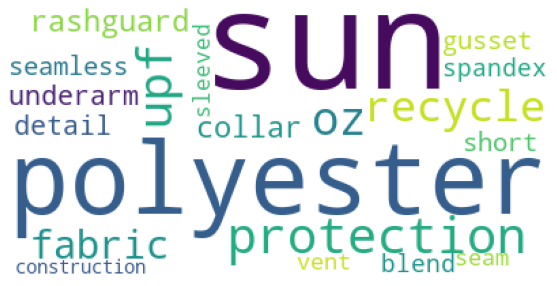

-*-*-*-*-*-*-*-*-*-*-*-* The 20 most common words for group 10 -*-*-*-*-*-*-*-*-*-*-*-*


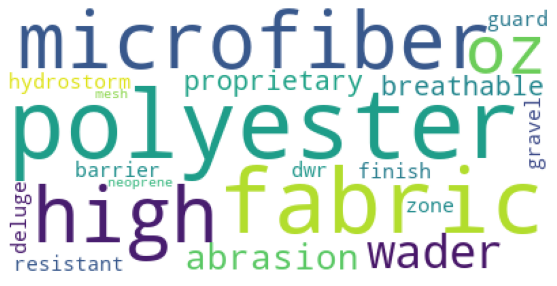

In [17]:
wd = WordCloud(stopwords=STOP_WORDS, collocations=False, max_words=20, background_color='white')

for i in range(1, len(np.unique(topic_encoded_df.main_topic))+1):

    cloud = wd.generate(" ".join(topic_encoded_df.loc[topic_encoded_df.main_topic==i, "clean_text"]))
    plt.figure(figsize=(12,5))
    # plt.title("WordCloud for topic {} ".format(i))
    print("-*"*12,"The 20 most common words for group {}".format(i),"-*"*12)
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()